# All training data

In [1]:
%config Completer.use_jedi = False

### 
- now using 
    - 20211029_011638: ./dir_kicker/logs/files__all_train_kfold_20211029_031110.csv


- all data
    - (Don't use) 20211025_012816: ./logs/files_20211025_020358_alldata.csv
    - (Use) files_20220212_200237_alldata.csv
    
        - or 
            - scripts/dir_kicker/logs/kicker.sh.o205129
            - 

## Load Model

In [2]:
from analysis_util import pdread
import pandas as pd
from scipy.special import expit, softmax
from sklearn.metrics import roc_auc_score
import os, sys
import joblib, functools
from functools import partial
import pickle
from sklearn.model_selection import KFold

sys.path.append('../recipes/')
import dataset
MCPASDataset = dataset.MCPASDataset


def get_file_paths(bucket, dirname, feat_name, extension='.parquet'):
    import boto3
    dataroot = f"s3://{bucket}/"
    objs = boto3.resource("s3").Bucket(f"{bucket}").objects.filter(
        Prefix=f"{dirname}/{feat_name}")
    files = [obj.key for obj in objs
             if not obj.key.startswith(f"{dirname}.ipynb_checkpoints") and obj.key.endswith(extension)]
    files = [os.path.join(dataroot, f) for f in files]
    return files


def delete_padding(weights1):
    if len([c for c in weights1.columns if '8_' in c])>0: 
        weights1 = weights1.drop(columns=[c for c in weights1.columns if '8_' in c])
    if len([c for c in weights1.index if '8_' in c])>0: 
        weights1 = weights1.drop(index=[c for c in weights1.index if '8_' in c])
    return weights1

@functools.lru_cache(maxsize=10)
def get_data_i_from_attenmatdict(ind):
    '''Get the data: attention, tcra, tcrb, peptides, sign etc'''
    attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign = ATTENTION_MATRIX_DICT[ind]
    aseq_from_comma, bseq_from_comma =  abseq_with_comma.split(':')
    aseq = DF_TCR.iloc[ind]['tcra']
    bseq = DF_TCR.iloc[ind]['tcrb']
    assert aseq==aseq_from_comma
    assert bseq==bseq_from_comma
    abseq = convert_len(aseq, MAXLENGTH_A) + convert_len(bseq, MAXLENGTH_B) 
    peptide = convert_len(DF_TCR.iloc[ind]['peptide'], max_len_epitope)
    return attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign, aseq, bseq, abseq, peptide


def get_weight1_on_headi(attn_output_weights1, head_i, 
                                   aseq, maxlength_a, 
                                   bseq, maxlength_b, 
                                   peptide,
                                   sign
                                  ):
    weights1 = pd.DataFrame(attn_output_weights1[head_i])
    weights1 = pd.DataFrame(attn_output_weights1[head_i])
    weights1.index = [f"{tup[1]}_{tup[0]}" for tup in list(enumerate(convert_len(aseq, maxlength_a)))] +\
        [f"{tup[1]}_{tup[0]}" for tup in list(enumerate(convert_len(bseq, maxlength_b)))]
    weights1.columns = [f"{tup[1]}_{tup[0]}" for tup in list(enumerate(peptide))]

    weights1 = delete_padding(weights1)
    weights1 = weights1.melt(ignore_index=False).reset_index().rename(columns={'variable':'peptide', 'index':'tcr'})
    weights1['sign'] = sign
    weights1['atten_head'] = head_i
    return weights1


def get_weight2_on_headi(attn_output_weights2, head_i, 
                           aseq, maxlength_a, 
                           bseq, maxlength_b,
                           peptide,
                           sign):
    weights2 = pd.DataFrame(attn_output_weights2[head_i])
    weights2.index = [f"{tup[1]}_{tup[0]}" for tup in list(enumerate(peptide))]
    weights2.columns = [f"{tup[1]}_{tup[0]}" for tup in list(enumerate(convert_len(aseq, maxlength_a)))] + \
        [f"{tup[1]}_{tup[0]}" for tup in list(enumerate(convert_len(bseq, maxlength_b)))]
    weights2 = delete_padding(weights2)
    weights2 = weights2.melt(ignore_index=False).reset_index().rename(columns={'variable':'tcr', 'index':'peptide'})
    weights2['sign'] = sign
    weights2['atten_head'] = head_i
    return weights2



def get_attention_weights_from_index(attention_matrix_dict, index):
    weights1_list = []
    weights2_list = []

    for head_i in range(4):
        for ind in tqdm(index):            
            attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign, aseq, bseq, abseq, peptide = \
                get_data_i_from_attenmatdict(ind)

            weights1 = get_weight1_on_headi(attn_output_weights1, head_i, 
                                   aseq, MAXLENGTH_A, 
                                   bseq, MAXLENGTH_B,
                                   peptide,
                                   sign
                                  )
            
            weights1_list.append(weights1)
            
            weights2 = get_weight2_on_headi(attn_output_weights2, head_i, 
                                   aseq, MAXLENGTH_A, 
                                   bseq, MAXLENGTH_B,
                                   peptide,
                                   sign)
            
            weights2_list.append(weights2)

        weights1_total = pd.concat(weights1_list)
        weights1_total['type'] = f'weights1_total: sum1onPeptide'
        weights2_total = pd.concat(weights2_list)
        weights2_total['type'] = f'weights2_total: sum1onTCR'
    df_attention_weights = pd.concat([weights1_total, weights2_total])
    _split_tcr = pd.DataFrame(df_attention_weights['tcr'].str.split('_', 1).tolist())
    _split_tcr.columns = ['tcr', 'position_of_tcr']
    _split_tcr['position_of_tcr'] = _split_tcr['position_of_tcr'].astype(int)
    _split_peptide = pd.DataFrame(df_attention_weights['peptide'].str.split('_', 1).tolist())
    _split_peptide.columns = ['peptide', 'position_of_peptide']
    _split_peptide['position_of_peptide'] = _split_peptide['position_of_peptide'].astype(int)
    
    df_attention_weights = df_attention_weights.rename(columns={'tcr':'tcr_position', 'peptide':'peptide_position'})
    df_attention_weights = pd.concat([df_attention_weights.reset_index(drop=True), 
               _split_tcr.reset_index(drop=True), 
               _split_peptide.reset_index(drop=True)], axis=1)
    df_attention_weights['cross_layer_side'] = df_attention_weights['type'].str.split(': ').str.get(1)
    return df_attention_weights

def get_attention_weights(dataset_test, model, index=0):
    analysis_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)
    for i, (xx,yy) in enumerate(analysis_loader):
        if i==index:
            break
    __xx = [x.to(device) for x in xx]
    #print(__xx)
    explain_model = Explain_TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                                     n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                                     n_tok=n_tok, n_pos1=n_pos1, n_pos2=n_pos2, n_seg=n_seg)
    explain_model.load_state_dict(model.state_dict(), strict=False)
    model.to(device)
    explain_model = explain_model.to(device)
    model = model.eval()
    explain_model = explain_model.eval()
    
    with torch.no_grad():
        tcrab, epitope, src_kwargs, tgt_kwargs = explain_model(__xx)  #  (L,B,E)
        attn_output1, attn_output_weights1 = model.enc.cgr.mha.fg.f.mha(
            query=tcrab,  # target  27
            key=epitope,   # source  10  (source is usually the output of encoder)
            value=epitope,   # source  10  
            **{'key_padding_mask': tgt_kwargs['memory_key_padding_mask']}
        )

        attn_output2, attn_output_weights2 = model.enc.cgr.mha.fg.g.f.mha(
            query=epitope, 
            key=tcrab, 
            value=tcrab,
            **{'key_padding_mask': src_kwargs['memory_key_padding_mask']}
        )
        
        ypred = model(__xx)
    return attn_output_weights1, attn_output_weights2, ypred


def vis_attn_to_tcr_from_epitope(attn_output_weights1, tcr_ab_seq, episeq):
    attention_weight = attn_output_weights1[0][:len(tcr_ab_seq), :len(episeq)]
    print((attention_weight.sum(axis=1)))
    x_label = [f'{x}_{i}' for i,x in enumerate(
        list(episeq) + ['<pad>']*(attention_weight.shape[1]-len(episeq)))]
    y_label = [f'{x}_{i}' for i,x in enumerate(
        list(tcr_ab_seq) + ['<pad>']*(attention_weight.shape[0]-len(tcr_ab_seq)))]
    fig = px.imshow(attention_weight, x=x_label, y =y_label,  width=500, height=600)
    fig.update_layout(autosize=False)
    fig.show()

def vis_attn_to_epitope_from_tcr(attn_output_weights2, tcr_ab_seq, episeq):
    attention_weight = attn_output_weights2[0][:len(episeq), :len(tcr_ab_seq)]
    print((attention_weight.sum(axis=1)))
    x_label = [f'{x}_{i}' for i,x in enumerate(
        list(episeq) + ['<pad>']*(attention_weight.shape[0]-len(episeq)))]
    y_label = [f'{x}_{i}' for i,x in enumerate(
        list(tcr_ab_seq) + ['<pad>']*(attention_weight.shape[1]-len(tcr_ab_seq)))]
    fig = px.imshow(attention_weight, x=y_label, y =x_label, width=600, height=600)
    fig.update_layout(autosize=False)
    fig.show()



def remove_UNK_and_take_subset(df_train):
    df_nounk = df_train[df_train['tcra']!='UNK']
    print("df_nounk.value_counts() \n\t ", df_nounk.sign.value_counts().to_dict())
    print("df_nounk.drop_duplicates('tcrb') \n\t ", df_nounk.drop_duplicates('tcrb').sign.value_counts().to_dict())
    return df_nounk

In [3]:
# FNAME ='../../scripts/dir_kicker/logs/files_fake020211027_051219.csv'
# FNAME ='files__all_train_kfold_20211029_031110.csv'

FNAME ='../scripts/dir_kicker/logs/files_20220212_200237_alldata.csv'

INTERGER_SELECTOR = 1
logdf = pd.read_csv(FNAME)
dt = logdf.checkp[INTERGER_SELECTOR].split('/')[-1]

print('dt', dt)

# CHECK_POINT_DIR = f'../../../tcrpred/../checkpoint/{dt}/'
CHECKPOINT_DIR = f's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}'

OUT_DIR = '../../../tcr_attention_cachedir'

PATH = f"./fakedata_v0.parquet"  # This is for torch.Dataset
KFOLD_I = logdf.knum[INTERGER_SELECTOR].item()
print('KFOLD_I', KFOLD_I)
REPLACE_TUPLE = ('~/jupyter_notebook/user_work/tcrpred/scripts/../../hhyylog/', 
                 '../../../hhyylog/')

checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')
checkpoint_files_withdt = [f for f in checkpoint_files if f'_{dt}_' in f]

CHECKPOINT_PATH = checkpoint_files_withdt[0].split('/')[-1]

# os.system(f'''aws s3 sync {CHECKPOINT_DIR}/ ./../../../checkpoint/{dt}/''')
# os.system(f'''aws s3 sync s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/{dt}_results_attention_tra.pickle ./../../hhyylog/''')


dt 20220211_191954
KFOLD_I 3


In [4]:
checkpoint_files_withdt

['s3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20220211_191954/best_20220211_191954_checkpoint_94_pr_auc_on_one=0.7952.pt',
 's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20220211_191954/best_20220211_191954_checkpoint_96_pr_auc_on_one=0.7978.pt']

In [5]:
!aws s3 ls s3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}/

2022-03-09 12:48:02   28750105 best_20220211_191951_checkpoint_100_pr_auc_on_one=0.7924.pt
2022-03-09 12:48:03   28750105 best_20220211_191951_checkpoint_99_pr_auc_on_one=0.7901.pt
2022-03-09 12:49:03   28750105 best_20220211_191954_checkpoint_94_pr_auc_on_one=0.7952.pt
2022-03-09 12:49:03   28750105 best_20220211_191954_checkpoint_96_pr_auc_on_one=0.7978.pt


In [6]:
hhfiles = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/hhyylog', '', '.pickle')
hhfiles_withdt = sorted([f for f in hhfiles if dt in f and f'k{KFOLD_I}' in f])
hhfiles_withdt

['s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/20220211_191954_k3_datasettest.pickle',
 's3://sg-playground-kkoyama-temp/tcrpred/hhyylog/20220211_191954_k3_test_hh.pickle',
 's3://sg-playground-kkoyama-temp/tcrpred/hhyylog/20220211_191954_k3_test_yy.pickle']

## Recover model

In [7]:
import sys, os
sys.path.append('../')
torch_check_point_local = '../../checkpoint/'
import json, torch
from recipes.model import TCRModel
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = DEVICE

n_tok = 29  # NUM_VOCAB
n_pos1 = 62  # MAX_LEN_AB (sum of maxlens of a and b)
n_pos2 = 26  # MAX_LEN_Epitope
n_seg = 3

# parameters
with open(f'../hpo_params/optuna_best.json', 'r') as fp:
    hparams = json.load(fp)

d_model, d_ff, n_head,n_local_encoder,n_global_encoder = hparams['d_model'], hparams['d_ff'], hparams['n_head'], hparams['n_local_encoder'], hparams['n_global_encoder']
dropout=hparams['dropout']
early_stopping_target = "pr_auc_on_one"
batch_size = hparams['batch_size']
lr=hparams['lr']

'''Model, optim, trainer'''
model = TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                 n_tok=n_tok, n_pos1=n_pos1,
                n_pos2=n_pos2, n_seg=n_seg,
                )

# Optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Loss
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 15.0], device=device))

trainer = create_supervised_trainer(
    model=model, optimizer=optim, loss_fn=loss_fn, device=device,
)

## Get the prediction and the best model
to_load = {'model': model, 'optimizer': optim, 'trainer': trainer}

checkpoint = torch.load(os.path.join(torch_check_point_local, CHECKPOINT_PATH), map_location=torch.device(device))

checkpoint['trainer']['seed'] = 9

Checkpoint.load_objects(to_load=to_load, checkpoint=checkpoint)


# Score of Results

In [8]:
import warnings
import torch, os, sys
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
sys.path.append('../')
sys.path.append('../..')
from attention_extractor import Explain_TCRModel, Explain_Before_Cross
from Bio.PDB import *
from Bio.PDB.PDBParser import PDBParser


display(logdf)



,knum,yyyymmdd,hhpath,yypath,checkp,sh.o.file,sh.o.name
0,1,20220211_191950,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/~/jupyter_notebook/user_work/tcrpred/scripts...,kicker.sh.o205128
1,3,20220211_191954,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/~/jupyter_notebook/user_work/tcrpred/scripts...,kicker.sh.o205130
2,0,20220211_191951,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/~/jupyter_notebook/user_work/tcrpred/scripts...,kicker.sh.o205127
3,2,20220211_191950,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/~/jupyter_notebook/user_work/tcrpred/scripts...,kicker.sh.o205129
4,4,20220211_192004,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/jupyter_notebook/user_work/tcrpred/scripts/....,~/~/jupyter_notebook/user_work/tcrpred/scripts...,kicker.sh.o205131


## All Score (Train + Valid)

(175211,) (175211,)
- acc 0.8010170594312
- balanced_acc 0.8610591678937332
- precision on 1:  0.45304500024536665
- precision on 0:  0.9874910149196164
- confusion matrix tn, fp, fn, tp: 112651, 33437, 1427, 27696
- roc_auc_score 0.9289183509705629
- pr_auc_score on 1 0.7290842933535833
- pr_auc_score on 0 0.9847696330980469


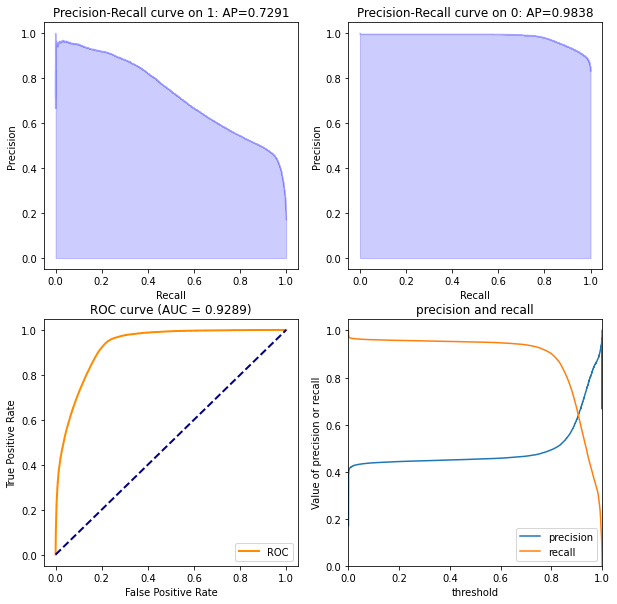

None


In [9]:
hh = pdread(hhfiles_withdt[1])
hh_result = hh.apply(softmax, axis=1)
hh_all = hh_result[1]

yy = pdread(hhfiles_withdt[2])
yy = yy[0]
print(hh_all.shape, yy.shape)


AA_DICT = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'GLIN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 'GLY': 'G',
     'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'ALA': 'A', 'VAL':'V',
     'GLU': 'E', 'TYR': 'Y', 'MET': 'M', 'SEC':'U', 'PYL':'O', 'HOH':'X'}

SEED = 9
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


DEVICE = 'cpu'
from utils import get_infer_report, get_metrics
print(get_infer_report(yy, hh_all))

In [10]:
sys.path.append('./../scripts/')
from dataset_selector import get_df_from_path
from tqdm import tqdm

# p_list = [f"../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
#           f"../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
#         f"../../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
#           f"../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",]
# df_all = get_df_from_path(p_list)
# print('df_all.shape', df_all.shape, end=' -> ')
# df_all_nounk = df_all[(df_all.tcra!='UNK')]
# print('df_all_nounk.shape', df_all.shape)


## Valid Score

In [11]:

p_list = [f"../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
          f"../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
        f"../../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
          f"../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",]

df_all = get_df_from_path(p_list)

# print('df_all.shape', df_all.shape, end=' -> ')
# df_all = df_all[(df_all.tcra!='UNK')]

print('df_all.shape', df_all.shape)

print("df_all(train).value_counts() \n\t", df_all.sign.value_counts().to_dict())

kf = KFold(n_splits=5, shuffle=True, random_state=2)
train_index, valid_index = [
    (train_index, valid_index) for train_index, valid_index in kf.split(df_all)
][KFOLD_I]
df_train, df_valid = df_all.loc[train_index], df_all.loc[valid_index]

dataset_train, dataset_valid = MCPASDataset(df_train), MCPASDataset(df_valid)
model = model.eval()
with torch.no_grad():
    analysis_loader = torch.utils.data.DataLoader(dataset=dataset_valid, batch_size=128, shuffle=False)
    ret_list = []
    yy_list = []
    for xx, yy in tqdm(analysis_loader):
        hh = model(xx)
        ret_list.append(hh)
        yy_list.append(yy)

yy_all_valid = np.concatenate([r.numpy() for r in yy_list])
hh_all_valid = np.concatenate([softmax(r, axis=1)[:,1].numpy() for r in ret_list])

  0%|                                                                                          | 0/275 [00:00<?, ?it/s]

df_all.shape (349578, 11)
df_all(train).value_counts() 
	 {0: 291315, 1: 58263}
datasize and y-vcounts:  (140082, 11) 0    116757
1     23325
Name: sign, dtype: int64
datasize and y-vcounts:  (35129, 11) 0    29331
1     5798
Name: sign, dtype: int64


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [02:42<00:00,  1.69it/s]


- acc 0.7381650488200632
- balanced_acc 0.7438468511247995
- precision on 1:  0.35978225008248105
- precision on 0:  0.9375787872201695
- confusion matrix tn, fp, fn, tp: 21569, 7762, 1436, 4362
- roc_auc_score 0.8254592269046206
- pr_auc_score on 1 0.47552149993872506
- pr_auc_score on 0 0.9598064253075909


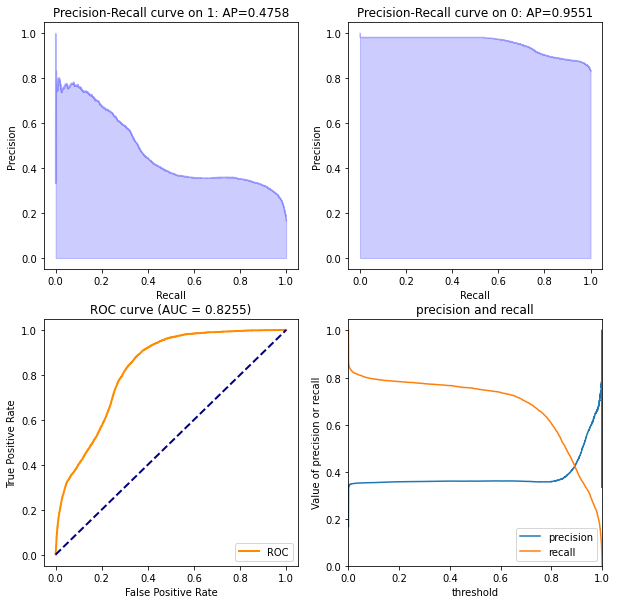

None


In [12]:
from utils import get_infer_report, get_metrics
print(get_infer_report(yy_all_valid, hh_all_valid))

## Valid Score by in-train-pep or by not-in-train-pep

In [14]:
df_train = dataset_train.data
df_valid = dataset_valid.data

df_valid['y_true'] = yy_all_valid
df_valid['y_pred'] = hh_all_valid

count pep in-train 29186
count pep not-in-train 56
1    29
0    27
Name: y_true, dtype: int64
- acc 0.5535714285714286
- balanced_acc 0.5625798212005109
- precision on 1:  0.6428571428571429
- precision on 0:  0.5238095238095238
- confusion matrix tn, fp, fn, tp: 22, 5, 20, 9
- roc_auc_score 0.7126436781609196
- pr_auc_score on 1 0.7372434935741556
- pr_auc_score on 0 0.699974862039869


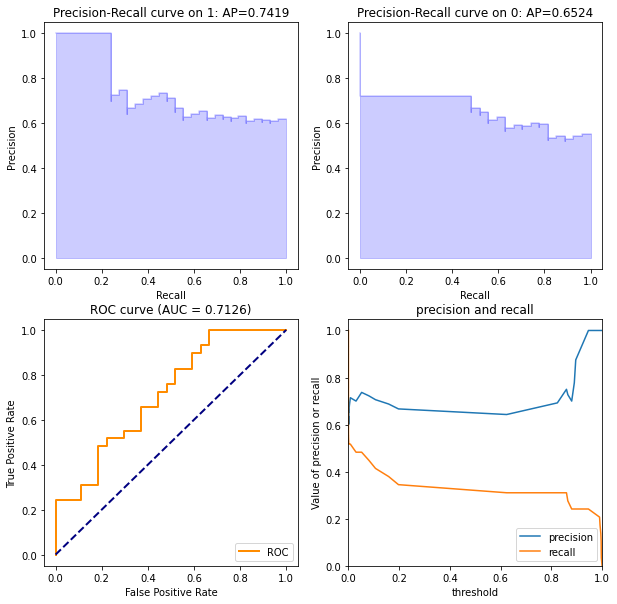

****************************************************************************************************
0    23417
1     5769
Name: y_true, dtype: int64
- acc 0.6878297814020421
- balanced_acc 0.712971380024437
- precision on 1:  0.36130478087649404
- precision on 0:  0.917376590033843
- confusion matrix tn, fp, fn, tp: 15722, 7695, 1416, 4353
- roc_auc_score 0.7886987031487637
- pr_auc_score on 1 0.4839350874186375
- pr_auc_score on 0 0.9390719853943597


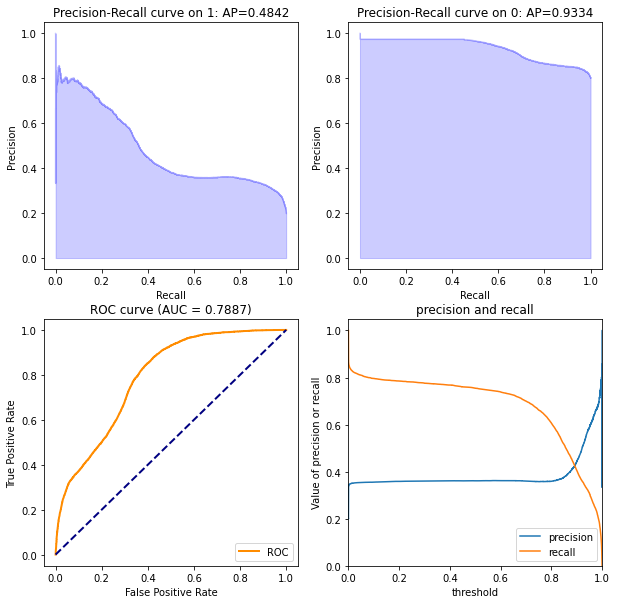

In [15]:
valid_pos_pep = df_valid.query('sign==1').peptide
train_pos_pep = df_train.query('sign==1').peptide


pep_not_in_train = valid_pos_pep[~valid_pos_pep.isin(train_pos_pep)]
pep_in_train = valid_pos_pep[valid_pos_pep.isin(train_pos_pep)]

df_valid_not_in_train = df_valid[df_valid.peptide.isin(pep_not_in_train)]
df_valid_in_train = df_valid[df_valid.peptide.isin(pep_in_train)]

print('count pep in-train', df_valid_in_train.shape[0])
print('count pep not-in-train', df_valid_not_in_train.shape[0])

print(df_valid_not_in_train.y_true.value_counts())

get_infer_report(df_valid_not_in_train.y_true, df_valid_not_in_train.y_pred)

print('*'*100)
print(df_valid_in_train.y_true.value_counts())
get_infer_report(df_valid_in_train.y_true, df_valid_in_train.y_pred)

## Train Score

100%|████████████████████████████████████████████████████████████████████████████████| 548/548 [09:13<00:00,  1.01s/it]


- acc 0.8157008038149084
- balanced_acc 0.8891668570337377
- precision on 1:  0.474628385257585
- precision on 0:  0.9998241217077782
- confusion matrix tn, fp, fn, tp: 90956, 25801, 16, 23309
- roc_auc_score 0.9524846671545021
- pr_auc_score on 1 0.7952145936629218
- pr_auc_score on 0 0.9906427630244594


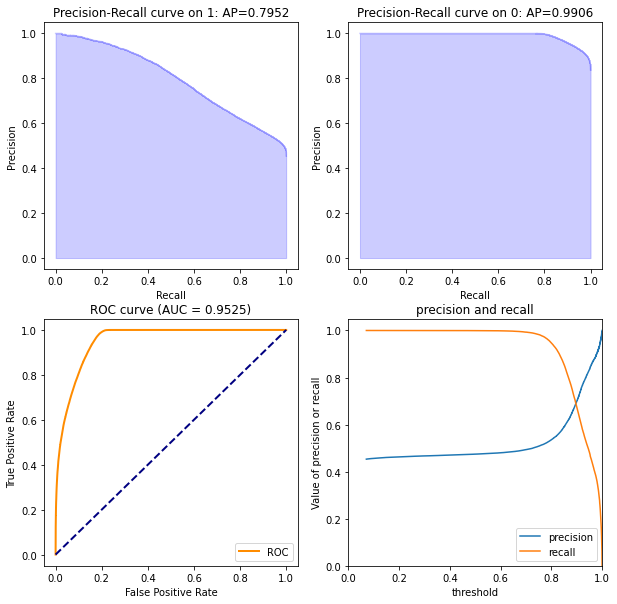

None


In [15]:
model = model.eval()
with torch.no_grad():
    analysis_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=256, shuffle=False)
    ret_list = []
    yy_list = []
    for xx, yy in tqdm(analysis_loader):
        hh = model(xx)
        ret_list.append(hh)
        yy_list.append(yy)
        
yy_all_train = np.concatenate([r.numpy() for r in yy_list])
hh_all_train = np.concatenate([softmax(r, axis=1)[:,1].numpy() for r in ret_list])

from utils import get_infer_report, get_metrics
print(get_infer_report(yy_all_train, hh_all_train))

In [16]:
print('all, train, valid')
print(df_all.shape[0], len(dataset_train), len(dataset_valid))

all, train, valid
349578 140082 35129


In [17]:
len(dataset_train)/df_all.shape[0], len(dataset_valid)/df_all.shape[0]

(0.4007174364519506, 0.1004897333356218)

In [18]:
df_valid[df_valid.tcra!='UNK'].to_parquet('../data/valid_allDataTrainedModel.parquet')

In [19]:
df_train[df_train.tcra!='UNK'].to_parquet('../data/train_allDataTrainedModel.parquet')

# Attention

In [ ]:
CHECKPOINT_PATH

### Copy attention-mat and checkpoint from s3 to local

In [ ]:
torch_check_point_local = '../../checkpoint/'
fro = os.path.join(CHECKPOINT_DIR, CHECKPOINT_PATH)
if not os.path.exists(os.path.join(torch_check_point_local, CHECKPOINT_PATH)):
    print('loading...')
    os.system(f'''aws s3 cp {fro} {torch_check_point_local}''')
    

In [ ]:
os.system(f'''aws s3 cp {fro} ./''')

In [ ]:
!ls -lh {torch_check_point_local}

In [ ]:
# !gita best_20220211_191954_checkpoint_94_pr_auc_on_one=0.7952.pt

In [ ]:
!aws s3 cp s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/{dt}_results_attention_tra.pickle  ../../hhyylog/

In [ ]:
import pickle
results_attention_tra = pickle.load(open(f'../../hhyylog/{dt}_results_attention_tra.pickle','rb'))

In [ ]:
len(results_attention_tra)

# Attention Extractor

In [ ]:
from recipes.dataset import TCRDataset
import plotly.express as px
from recipes.dataset import Vocab, Dataset

## Fix Index to get a specific pdb, interaction

In [ ]:
def get_values_from_index(ind, df):
    PDBID = df['pdb_id'].iloc[ind]
    DATA_SERIESE = df.iloc[ind]
    e_pdb_chain, tcr_c1_pdb_chain,tcr_c2_pdb_chain,chain1_cdr3_start_calculated,chain1_cdr3_end_calculated,chain2_cdr3_start_calculated, chain2_cdr3_end_calculated =\
                DATA_SERIESE[['e_pdb_chain', 'tcr_c1_pdb_chain','tcr_c2_pdb_chain',
                        'chain1_cdr3_start_calculated', 'chain1_cdr3_end_calculated',
                    'chain2_cdr3_start_calculated', 'chain2_cdr3_end_calculated']]
    return PDBID, e_pdb_chain, tcr_c1_pdb_chain,tcr_c2_pdb_chain,chain1_cdr3_start_calculated,chain1_cdr3_end_calculated,chain2_cdr3_start_calculated, chain2_cdr3_end_calculated


# DF_TCR and attention_matrix_dict

In [ ]:
from attention_extractor import Explain_TCRModel, Explain_Before_Cross
import gc
import pickle
from tqdm import tqdm

DF_TCR = df_train
attn_output_weights1, attn_output_weights2, ypred = get_attention_weights(dataset_train, model, index=0)
# !aws s3 cp s3://sg-playground-kkoyama-temp/tcrpred/tcr_attention_cachedir/20211029_011638_attention_matrix_dict.pickle ../../tcr_attention_cachedir/

NNN = len(dataset_train)

assert NNN==len(df_train)

# if False: #
if os.path.exists(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle'):
    print('reading attention_matrix_dict.pickle.... \n', f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle')
    ATTENTION_MATRIX_DICT = pickle.load(open(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle','rb'))
else:
    ATTENTION_MATRIX_DICT = {}
    i=0
    for ind_row, attn in  tqdm(zip(df_train.iterrows(), results_attention_tra)): #tqdm(range(NNN)):
        ind, row = ind_row
        attn_output_weights1, attn_output_weights2, ypred, ytrue = attn #get_attention_weights(dataset_train, model, index=ind)
        ATTENTION_MATRIX_DICT[i] = (attn_output_weights1, 
                                      attn_output_weights2,  
                                      row['tcra'] + ':' + row['tcrb'], 
                                      row['peptide'], 
                                      ypred, 
                                      row['sign'])
        gc.collect()
        i+=1
    pickle.dump(ATTENTION_MATRIX_DICT, open(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle', 'wb'))
    